### IS backtest

#### Data Preprocessing

In [1]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm

from datetime import datetime,timedelta, timezone

In [2]:
def get_vn30f1m_trading(start, ticker):
    """
    Fetch VN30F1M trading data from the API.

    Parameters:
    start (int): The start timestamp.
    ticker (str): The ticker symbol.

    Returns:
    pd.DataFrame: A DataFrame containing the trading data.
    """
    end = '9999999999'
    url = f"https://services.entrade.com.vn/chart-api/chart?from={start}&resolution=1&symbol={ticker}&to={end}"
    try:
        resp = requests.get(url)
        data = resp.json()
        if not data:
            print(f"No data returned for {ticker}")
        vn30f1m = pd.DataFrame(data).iloc[:, :6]
        vn30f1m['t'] = vn30f1m['t'].astype(int).apply(lambda x: (datetime.fromtimestamp(x, timezone.utc) + timedelta(hours=7)).replace(tzinfo=None))
        vn30f1m.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        return vn30f1m
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}.")
        return pd.DataFrame()

vn30f1m = get_vn30f1m_trading('0', 'VN30F1M')
vn30f1m

,date,open,high,low,close,volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
331470,2024-08-06 14:27:00,1254.2,1254.2,1252.2,1252.5,2211
331471,2024-08-06 14:28:00,1252.2,1253.3,1252.2,1253.2,1551
331472,2024-08-06 14:29:00,1252.8,1253.0,1252.3,1252.8,1854
331473,2024-08-06 14:30:00,1252.5,1252.5,1252.5,1252.5,115


#### Extract only VN30F1M close price at 14pm

In [3]:
vn30f1m['date'] = pd.to_datetime(vn30f1m['date'])
vn30f1m = vn30f1m[vn30f1m['date'].dt.time == pd.to_datetime('14:00:00').time()]
vn30f1m = vn30f1m[['date', 'close']]
vn30f1m.set_index('date', inplace=True)
vn30f1m.index = vn30f1m.index.date
vn30f1m.index.name = 'date'
vn30f1m.dropna(inplace=True)
vn30f1m

,close
date,
2018-08-13,948.9
2018-08-14,959.1
2018-08-15,958.6
2018-08-16,943.1
2018-08-17,946.8
...,...
2024-07-31,1298.2
2024-08-01,1285.9
2024-08-02,1266.1


#### IS-OS split

In [4]:
vn30f1m_train = vn30f1m.iloc[:-100]
vn30f1m_test = vn30f1m.iloc[-100:]

#### Scraping HSI price data

In [5]:
import yfinance as yf
import pytz

ticker_list = ['^HSI']

ticker_intraday_prices = pd.DataFrame()
ticker_intraday_prices = {}

item = ticker_list[0]
print(f"Downloading data for: {item}")

download_data = yf.download(tickers=item, start='2018-08-13', end=datetime.now().strftime('%Y-%m-%d'))
download_data.index = pd.to_datetime(download_data.index)

ticker_intraday_prices[item] = download_data

print(ticker_intraday_prices[item])
print(ticker_intraday_prices[item].shape)

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2018-08-13  27956.779297  28085.169922  27823.210938  27936.570312   
2018-08-14  27938.320312  27946.550781  27522.820312  27752.929688   
2018-08-15  27724.720703  27727.269531  27249.080078  27323.589844   
2018-08-16  26871.109375  27405.250000  26871.109375  27100.060547   
2018-08-17  27388.570312  27450.839844  27101.099609  27213.410156   
...                  ...           ...           ...           ...   
2024-07-30  17194.369141  17194.369141  16971.599609  17002.910156   
2024-07-31  17070.859375  17400.240234  17015.830078  17344.599609   
2024-08-01  17327.849609  17408.949219  17248.119141  17304.960938   
2024-08-02  17025.259766  17075.519531  16865.929688  16945.509766   
2024-08-05  16676.820312  16944.589844  16441.439453  16698.359375   

               Adj Close      Volume  
Date                                  
2018-08-13 

#### Extract HSI index close price 4pm (UTC)

In [6]:
hsi = ticker_intraday_prices[item]
hsi = hsi[['Close']]
hsi_train = hsi.iloc[:-100]
hsi_test = hsi.iloc[-100:]

#### Merge VN30F1M and HSI index price into one DataFrame

In [7]:
prices = pd.merge(vn30f1m_train, hsi_train, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices.index.name = 'Date'
prices

,VN30F1M,HSI
Date,,
2018-08-13,948.9,27936.570312
2018-08-14,959.1,27752.929688
2018-08-15,958.6,27323.589844
2018-08-16,943.1,27100.060547
2018-08-17,946.8,27213.410156
...,...,...
2024-02-29,1258.2,16511.439453
2024-03-01,1261.1,16589.439453
2024-03-04,1271.0,16595.970703


#### Trading hypothesis
- Yesterday's price of HSI > The day before yesterday's price of HSI, enter long position for VN30F1m

- Yesterday's price of HSI < The day before yesterday's price of HSI, enter short position for VN30F1m

- Else: do nothing (no position opened/close position)

#### T-test ANOVA

- Null Hypothesis (H₀): There is no difference between the means of VN30F1M and HSI

- Alternative Hypothesis (H₁): There is a difference between the means of VN30F1M and HSI

Interpretation:

- If the p-value < 0.05, it rejects the null hypothesis. In other words, it indicates that the difference between the means of VN30F1M and HSI is statistically significant.

- If the p-value >= 0.05, you would fail to reject the null hypothesis, indicating that there is no significant difference between the means of VN30F1M and HSI.

In [8]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(prices['VN30F1M'], prices['HSI'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -202.85992030692972
P-value: 0.0


- There is a statistically significant difference between the mean values of VN30F1M and HSI.

- The VN30F1M and HSI series are not likely to have the same mean values

#### Correlation

By computing rolling correlations, we can observe how the relationship between **VN30F1M** and **HSI** changes over time. This can reveal patterns such as periods of high correlation (when they move closely together) or low correlation (when their movements diverge).

In [9]:
window_size = 30
results = []

for i in range(len(prices) - window_size + 1):
    window = prices.iloc[i:i + window_size]
    correlation_coef = window['VN30F1M'].corr(window['HSI'])
    results.append(correlation_coef)

results = pd.DataFrame(results, columns=['Rolling Correlation'])
print(results)

      Rolling Correlation
0                0.566609
1                0.580176
2                0.565615
3                0.561502
4                0.478931
...                   ...
1180             0.687827
1181             0.748075
1182             0.793147
1183             0.812903
1184             0.775963

[1185 rows x 1 columns]


In [10]:
(results > 0).sum()

Rolling Correlation    866
dtype: int64

In [11]:
(results < 0).sum()

Rolling Correlation    319
dtype: int64

We have 1033 positive correlations and 318 negative correlations, the positive correlations do outnumber the negative correlations. This suggests that, overall, the assets tend to move ***in the same direction more frequently than in opposite directions***.

#### Trading strategy

In [12]:
def momentum_hsi(df):
    positions = []

    for i in range(2, len(df)):
        if df['HSI'].iloc[i - 1] > df['HSI'].iloc[i - 2]:
            positions.append(1)
        elif df['HSI'].iloc[i - 1] < df['HSI'].iloc[i - 2]:
            positions.append(-1)
        else:
            positions.append(0)
    
    positions.insert(0, 0)
    positions.insert(1, 0)
    df['Pos'] = positions
    return df

- If the current day's price is higher than the previous day's price, it suggests upward momentum, and the function appends 1 to the positions list.

- If the current day's price is lower than or equal to the previous day's price, it suggests downward or neutral momentum, and the function appends -1 to the positions list.

In [13]:
prices = momentum_hsi(prices)
prices

,VN30F1M,HSI,Pos
Date,,,
2018-08-13,948.9,27936.570312,0
2018-08-14,959.1,27752.929688,0
2018-08-15,958.6,27323.589844,-1
2018-08-16,943.1,27100.060547,-1
2018-08-17,946.8,27213.410156,-1
...,...,...,...
2024-02-29,1258.2,16511.439453,-1
2024-03-01,1261.1,16589.439453,-1
2024-03-04,1271.0,16595.970703,1


#### Vectorized PnL Backtest

In [14]:
def pnl(df):
    df['pnl'] = df['Pos'].shift() * (df['VN30F1M'] - df['VN30F1M'].shift())
    df['pnl'].iloc[0] = 0
    return df

In [15]:
prices = pnl(prices)
prices

<ipython-input-14-7cd7760709ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pnl'].iloc[0] = 0


,VN30F1M,HSI,Pos,pnl
Date,,,,
2018-08-13,948.9,27936.570312,0,0.0
2018-08-14,959.1,27752.929688,0,0.0
2018-08-15,958.6,27323.589844,-1,-0.0
2018-08-16,943.1,27100.060547,-1,15.5
2018-08-17,946.8,27213.410156,-1,-3.7
...,...,...,...,...
2024-02-29,1258.2,16511.439453,-1,-1.2
2024-03-01,1261.1,16589.439453,-1,-2.9
2024-03-04,1271.0,16595.970703,1,-9.9


#### Performance metrics

In [16]:
def backtest_price(price_series, position_series):
    bt = pd.DataFrame(price_series.diff() * position_series.shift())
    bt['date'] = [str(i)[:10] for i in bt.index]
    daily_pnl = bt.groupby('date').sum()
    cumulative_returns = daily_pnl.cumsum()
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns - running_max
    max_dd = (drawdown.min() / running_max.max()) * 100 
    sharpe = (daily_pnl.mean()/daily_pnl.std()*np.sqrt(252))[0]
    return sharpe, max_dd

In [17]:
sharpe, max_dd = backtest_price(prices['VN30F1M'], prices['Pos'])
print(f"Sharpe ratio: {sharpe}")
print(f"Max drawdown: {max_dd}")

Sharpe ratio: 1.2536086124930264
Max drawdown: 0   -21.035069
dtype: float64


## OOS backtest

In [18]:
prices = pd.merge(vn30f1m_test, hsi_test, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices

,VN30F1M,HSI
2024-03-13,1258.8,17082.109375
2024-03-15,1250.5,16720.890625
2024-03-18,1229.4,16737.119141
2024-03-19,1228.5,16529.480469
2024-03-20,1252.3,16543.070312
...,...,...
2024-07-30,1286.1,17002.910156
2024-07-31,1298.2,17344.599609
2024-08-01,1285.9,17304.960938
2024-08-02,1266.1,16945.509766


In [19]:
prices = momentum_hsi(prices)
prices

,VN30F1M,HSI,Pos
2024-03-13,1258.8,17082.109375,0
2024-03-15,1250.5,16720.890625,0
2024-03-18,1229.4,16737.119141,-1
2024-03-19,1228.5,16529.480469,1
2024-03-20,1252.3,16543.070312,-1
...,...,...,...
2024-07-30,1286.1,17002.910156,1
2024-07-31,1298.2,17344.599609,-1
2024-08-01,1285.9,17304.960938,1
2024-08-02,1266.1,16945.509766,-1


In [20]:
prices = pnl(prices)
prices

<ipython-input-14-7cd7760709ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pnl'].iloc[0] = 0


,VN30F1M,HSI,Pos,pnl
2024-03-13,1258.8,17082.109375,0,0.0
2024-03-15,1250.5,16720.890625,0,-0.0
2024-03-18,1229.4,16737.119141,-1,-0.0
2024-03-19,1228.5,16529.480469,1,0.9
2024-03-20,1252.3,16543.070312,-1,23.8
...,...,...,...,...
2024-07-30,1286.1,17002.910156,1,6.9
2024-07-31,1298.2,17344.599609,-1,12.1
2024-08-01,1285.9,17304.960938,1,12.3
2024-08-02,1266.1,16945.509766,-1,-19.8


<Axes: >

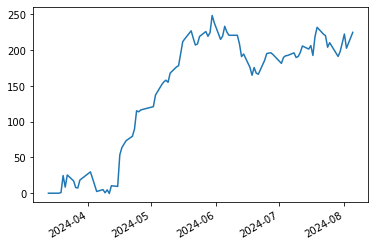

In [22]:
prices['pnl'].cumsum().plot()

In [21]:
sharpe, max_dd = backtest_price(prices['VN30F1M'], prices['Pos'])
print(f"Sharpe ratio: {sharpe}")
print(f"Max drawdown: {max_dd}")

Sharpe ratio: 3.173726271117304
Max drawdown: 0   -33.641851
dtype: float64
